In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats import mode, entropy
from scipy import interpolate
from scipy.spatial.distance import jensenshannon
import helper as hp

import warnings
warnings.filterwarnings('ignore')

In [3]:
def rmse_(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
    
def average_deviation(predictions, targets):
    return np.sum(np.abs(predictions - targets))/len(predictions)

def calc_E(all_sols, idx_to_plot):
    
    # Find average deviation
    E_df = pd.DataFrame(columns = ['solution_id', 'E_biomass', 'E_glc'])
    
    for sol_id in idx_to_plot:
    
        this_sol = all_sols[all_sols['solution_id']==sol_id]
        store_df_vals = []
        store_df_vals.append(sol_id)
    
        for conc, scaling in dict_scaling.items():
    
            #load experimental data
            exp_ = exp_data[conc]
            mean = exp_[exp_.columns[1]]
            time_exp = exp_[exp_.columns[0]]
            
            #interpolate simulated data to experimental time
            #if time_exp.values[-1]<this_sol['time'].values[-1]:
                
            f = interpolate.interp1d(this_sol['time'].values, this_sol[conc].values*scaling)
            simulated_interp = f(time_exp.values)
            #calculate rms error between experimental and interpolated simulated data
            this_E = average_deviation(mean.values, simulated_interp)
            store_df_vals.append(this_E)
    
            #else: store_df_vals.append(None)
        
        E_df.loc[sol_id] = store_df_vals

    return E_df

def plot_bioreactor(path_to_sol):
    
    all_sols= pd.read_csv(path_to_sol)
    all_sol_ids = np.unique(all_sols['solution_id'])
    
    ## Find models that finished integration and get their final biomasses
    
    all_plot_ix = []
    all_fin_biomasses = []
    for ix in all_sol_ids:
        ix_time = all_sols[all_sols['solution_id'] == ix]['time'].values
        if len(ix_time) == len(T): 
            all_plot_ix.append(ix)
            this_fin_biomass = all_sols[all_sols['solution_id'] == ix]['biomass_strain_1'].values[-1]
            all_fin_biomasses.append(this_fin_biomass*dict_scaling['biomass_strain_1'])
    
    #figure
    
    fig = plt.figure(figsize = (12,4)) 
    plot_ix = 1
    for conc, scaling in list(dict_scaling.items()):
    
        #load experimental data
        exp_ = exp_data[conc]
        mean = exp_[exp_.columns[1]]
        time_exp = exp_[exp_.columns[0]]
    
        plt.subplot(1,2,plot_ix)
    
        # Plot simulated data
        for sol_id in all_plot_ix:
            this_sol = all_sols[all_sols['solution_id']==sol_id]
            if len(this_sol[conc])==N_STEPS:
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)
                
        # Plot experimental data
        if len(exp_.columns) > 2:
            lo = exp_[exp_.columns[2]]
            hi = exp_[exp_.columns[3]]
            plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                         fmt='ko', capsize=5)
        else:
            plt.plot(time_exp, mean, 'ko')  
            plt.xlabel('time (h)')
            plt.ylabel(labels[conc], fontsize = 15)
            plt.xlim([0, 12])
    
        plot_ix+=1
        
    #plt.savefig(f'{plot_path}/sim_{ss_idx}_{rep}_{gen}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
    plt.legend()
    plt.show()
    plt.close()

def deprecautionize(x):
    if len(x) % 3 != 0:
        raise ValueError("The length of the input array must be divisible by 3.")
    
    x = np.array(x)  # Ensure the input is a numpy array
    modes = []
    
    for i in range(0, len(x), 3):
        chunk = x[i:i+3]
        modes.append(mode(chunk).mode[0])  # Compute the mode of the chunk and append
    return np.array(modes)

In [3]:
TOTAL_TIME = 15
N_STEPS = 100

T = np.linspace(0, TOTAL_TIME, N_STEPS)
T_start_ix = np.where(T<0.9603)[-1][-1]

growth = pd.read_csv('exp_data/biomass.csv')
glc = pd.read_csv('exp_data/glucose.csv')
dict_scaling = {'biomass_strain_1': 0.28e-12, 'glc_D_e': 1e-6}#, 'ac_e': 1e-6,
                #'etoh_e': 1e-6, 'for_e': 1e-6} # 1e-6 because we need to present the results in  (mM)
labels = {'biomass_strain_1': 'biomass (g/L)', 'glc_D_e': 'glucose (mM)'}#, 'ac_e': 'acetate (mM)',
          #'etoh_e': 'ethanol (mM)', 'for_e': 'formate (mM)'}
exp_data = {'biomass_strain_1': growth, 'glc_D_e': glc}#, 'ac_e': ac, 'etoh_e': eth, 'for_e': form}

all_exp_mets = [growth, glc]
final_exp_val = []
for this_met in all_exp_mets:
    final_exp_val.append(this_met.iloc[:,1].values[-1])
    
final_exp_ss = {}
for ix, key in enumerate(list(dict_scaling.keys())):
    final_exp_ss[key] = final_exp_val[ix]

In [4]:
# Model indexes
ss_idx = 3709
repeat = 1
gen = 23
valid_idx_og = 82

names_km = pd.read_csv(f'../models/varma_ecoli_anaerobic/parameter_names_km_fdp1.csv').iloc[:,1].values
n_kms = len(names_km)

## load og solution
og_sols = pd.read_csv(f'samples/{ss_idx}/{repeat}/sample_{gen}.csv')
og_eigs = pd.read_csv(f'samples/{ss_idx}/{repeat}/sample_{gen}_max_eigs.csv').iloc[:,1].values
reverse_valid_idx = np.where(np.where(og_eigs<=-0.9)[0] == valid_idx_og)[0][0]
og_sol = og_sols[og_sols['solution_id'] == reverse_valid_idx]

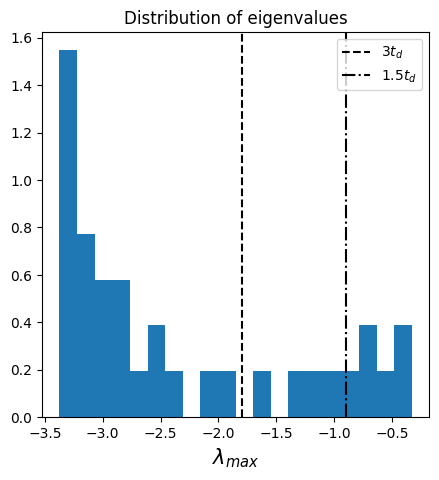

In [5]:
og_valid_eigs = og_eigs[np.where(og_eigs<=0)[0]]
plt.figure(figsize = (5,5))
plt.hist(og_valid_eigs, bins = 20, density = True)
plt.axvline(x = -1.8, color = 'k', ls = '--', label = r'$3t_d$')
plt.axvline(x = -0.9, color = 'k', ls = '-.', label = r'$1.5t_d$')
plt.xlabel(r'$\lambda_{max}$', fontsize = 15)
plt.title('Distribution of eigenvalues')
plt.legend()
plt.show()
plt.close()

### Study 2 - Check bioreactor simulations

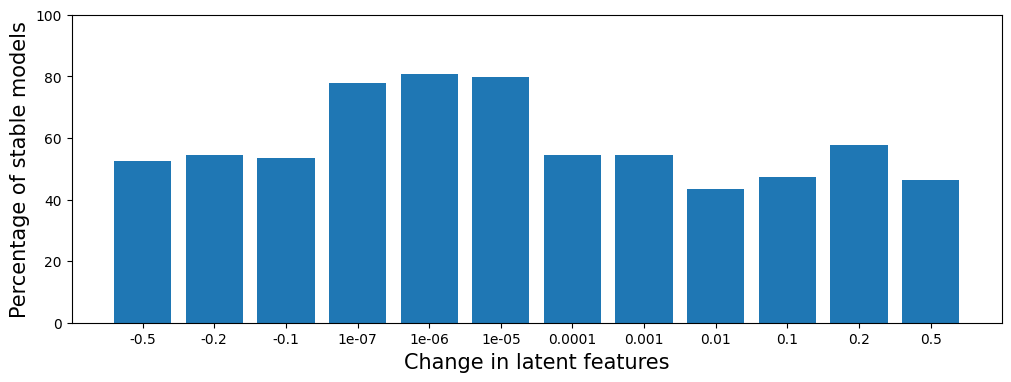

In [7]:
tolerances = [-0.5,-0.2,-0.1, 1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.1,0.2,0.5]
path = f'latent/{ss_idx}_{repeat}_{gen}/tolerance/'
pc_stable = []
pc_valid = []
for this_tol in tolerances:
    these_eigs = pd.read_csv(f'{path}sample_{this_tol}_max_eigs.csv').iloc[:,1].values
    pc_stable.append(len(np.where(these_eigs<=-0.9)[0])*100/len(these_eigs))
    pc_valid.append(len(np.where(these_eigs<=0)[0])*100/len(these_eigs))

plt.figure(figsize = (12,4))
plt.bar(np.arange(len(tolerances)), pc_stable)
#plt.bar(np.arange(len(tolerances)), pc_valid, alpha = 0.5)
plt.xticks(np.arange(len(tolerances)), tolerances)
plt.ylim([0,100])
plt.xlabel(f'Change in latent features', fontsize = 15)
plt.ylabel('Percentage of stable models', fontsize = 15)
plt.show()

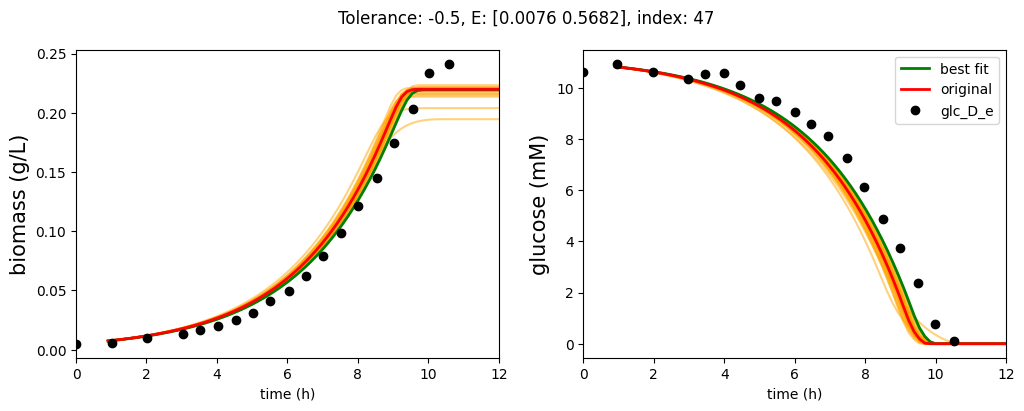

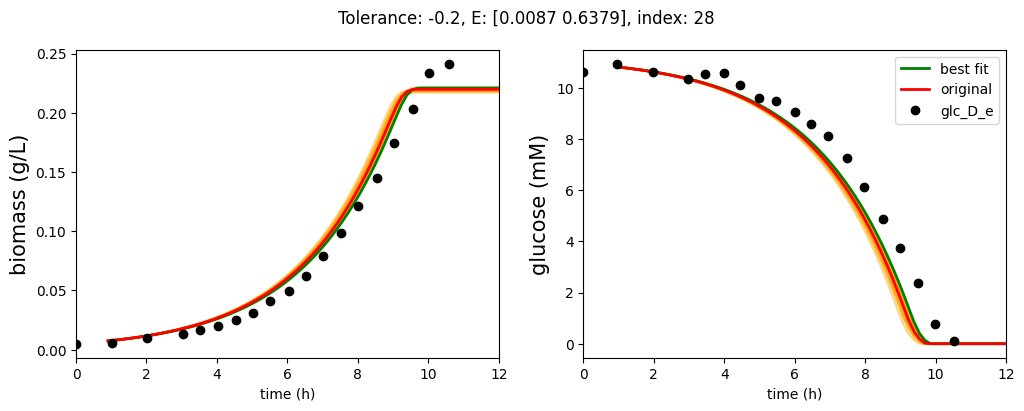

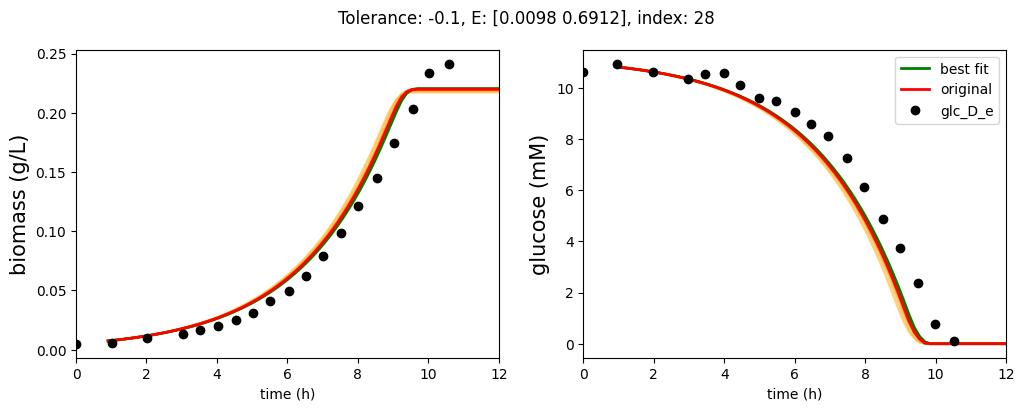

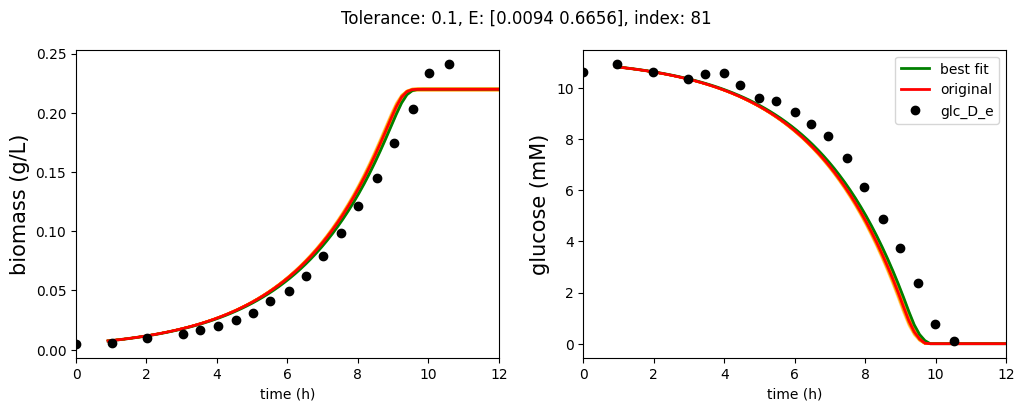

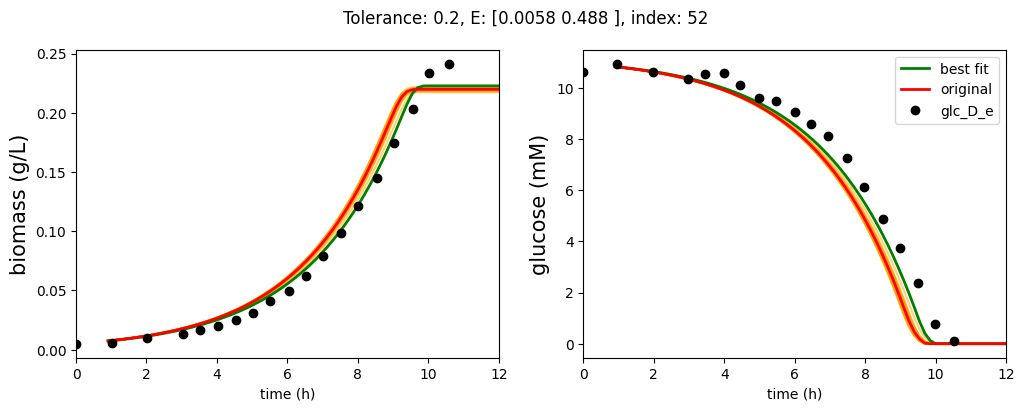

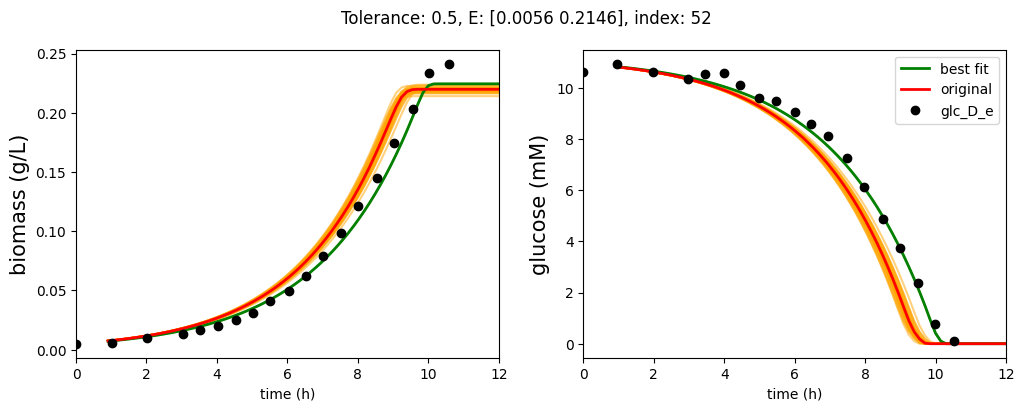

In [8]:
path = f'latent/{ss_idx}_{repeat}_{gen}/tolerance/'
tolerances = [-0.5,-0.2,-0.1,0.1,0.2,0.5]
PLOT = True

for tol in tolerances:
    
    #Load stuff
    path_to_sol = f'{path}sample_{tol}.csv'
    all_sols= pd.read_csv(path_to_sol)
    all_sol_ids = np.unique(all_sols['solution_id'])

    ## Find models that finished integration
    all_plot_ix = []
    for ix in np.unique(all_sols['solution_id']):
        ix_time = all_sols[all_sols['solution_id'] == ix]['time'].values
        if len(ix_time) == len(T): all_plot_ix.append(ix)
    
    path_to_max_eigs = f'{path}/sample_{tol}_max_eigs.csv'
    this_max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values
    valid_idx = np.where(this_max_eigs<=-0.9)[0]
    original_ix = valid_idx[all_plot_ix]
    
    ## Calculate
    if len(all_plot_ix)!=0:
        
        E_df = calc_E(all_sols, all_plot_ix)
        # Find solution with the lowest biomass E and its corresponding E_glc
        min_E_biomass = E_df['E_biomass'].min() # minimum E_biomass
        ix_min_E_biomass = int(E_df[E_df['E_biomass'] == min_E_biomass]['solution_id'].values[0])
        min_E_glc = E_df[E_df['solution_id'] == ix_min_E_biomass]['E_glc'].values[0]
        
        ix_best_model = valid_idx[ix_min_E_biomass]
        min_E = np.round([min_E_biomass, min_E_glc],4)

    
    ### Plot
    if PLOT:
        
        fig = plt.figure(figsize = (12,4)) 
        plot_ix = 1
        for conc, scaling in list(dict_scaling.items()):
    
            #load experimental data
            exp_ = exp_data[conc]
            mean = exp_[exp_.columns[1]]
            time_exp = exp_[exp_.columns[0]]
    
            plt.subplot(1,2,plot_ix)
    
            # Plot simulated data
            for sol_id in all_plot_ix:
                this_sol = all_sols[all_sols['solution_id']==sol_id]
                if len(this_sol[conc])==N_STEPS:
                    plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)

            
            # Plot best fit
            if len(all_plot_ix)!=0:
                this_sol = all_sols[all_sols['solution_id']==ix_min_E_biomass]
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'green', label = 'best fit')

            # Plot original
            plt.plot(T[T_start_ix:], og_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'red', label = 'original')
            
            
            # Plot experimental data
            if len(exp_.columns) > 2:
                lo = exp_[exp_.columns[2]]
                hi = exp_[exp_.columns[3]]
                plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                             fmt='ko', label= f'{conc}', capsize=5)
            else:
                plt.plot(time_exp, mean, 'ko', label=f'{conc}')  
                plt.xlabel('time (h)')
                plt.ylabel(labels[conc], fontsize = 15)
                plt.xlim([0, 12])
    
            plot_ix+=1
            
        fig.suptitle(f'Tolerance: {tol}, E: {min_E}, index: {ix_best_model}')

        #plt.savefig(f'{plot_path}/sim_{ss_idx}_{rep}_{gen}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
        plt.legend()
        plt.show()
        plt.close()

### Perturbing every latent feature -100% to 100%

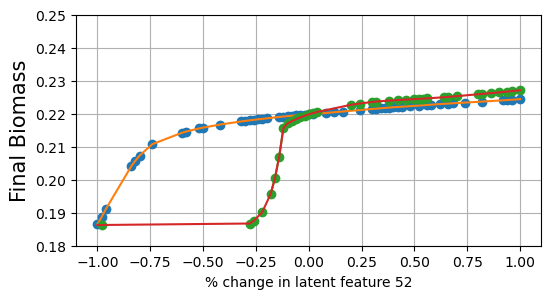

In [67]:
from scipy.interpolate import interp1d
final_biomasses = []
PLOT = False
tolerances = np.linspace(-1,1,101)
plt.figure(figsize = (6,3))
for ix_to_perturb in [51,52]:
    
    path = f'latent/{ss_idx}_{repeat}_{gen}/landscape/one/'
    name_ = f'82_{ix_to_perturb}'
    
    
    #Load stuff
    path_to_sol = f'{path}sample_{name_}.csv'
    all_sols= pd.read_csv(path_to_sol)
    all_sol_ids = np.unique(all_sols['solution_id'])
    
    ## Find models that finished integration and get their final biomasses
    
    all_plot_ix = []
    all_fin_biomasses = []
    for ix in all_sol_ids:
        ix_time = all_sols[all_sols['solution_id'] == ix]['time'].values
        if len(ix_time) == len(T): 
            all_plot_ix.append(ix)
            this_fin_biomass = all_sols[all_sols['solution_id'] == ix]['biomass_strain_1'].values[-1]
            all_fin_biomasses.append(this_fin_biomass*dict_scaling['biomass_strain_1'])
            
    path_to_max_eigs = f'{path}/sample_{name_}_max_eigs.csv'
    this_max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values
    valid_idx = np.where(this_max_eigs<=-0.9)[0]
    original_ix = valid_idx[all_plot_ix]

    #make it suitable for plotting
    wrapped_biomasses = np.zeros(303)
    wrapped_biomasses[original_ix] = all_fin_biomasses
    wrapped_biomasses = deprecautionize(wrapped_biomasses)
    wrapped_biomasses = np.where(wrapped_biomasses != 0, wrapped_biomasses, np.nan)  # Replace 0s with NaN
    
    not_nan = ~np.isnan(wrapped_biomasses)
    interp_func = interp1d(tolerances[not_nan], wrapped_biomasses[not_nan], kind='linear', bounds_error=False, fill_value="extrapolate")
    filled_biomasses = interp_func(tolerances)

    plt.plot(tolerances, wrapped_biomasses, 'o-')
    plt.plot(tolerances, filled_biomasses, '-')
    plt.ylim([0.18, 0.25])
    plt.ylabel('Final Biomass' , fontsize = 15)
    plt.xlabel(f'% change in latent feature {ix_to_perturb}')
    plt.grid(True)
    plt.savefig(f'figures/figure_5/final_biomasses_one/imp_latent_feature.svg', dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(f'figures/figure_5/final_biomasses_one/imp_latent_feature.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()

In [53]:
101*101

10201

In [49]:
path = f'latent/{ss_idx}_{repeat}_{gen}/landscape/one/'
tolerances = np.linspace(-1,1,101)

for ix in [51,52]:

    
    name_ = f'{valid_idx_og}_{ix}'
    
    these_eigs = pd.read_csv(f'{path}sample_{name_}_max_eigs.csv').iloc[:,1].values
    these_fin_biomasses = final_biomasses[ix]

    
    new_eigs = deprecautionize(these_eigs)
    negative_eigs = np.where(new_eigs < 0, new_eigs, np.nan)  # Replace positive values with NaN
    
    plt.figure(figsize = (12,3))

    plt.subplot(121)
    plt.plot(negative_eigs, 'o-', label="Negative values")
    plt.plot(50, -2.008, 'k^', ms = 10)
    
    plt.suptitle(f"Latent Feature {ix}")
    plt.xlabel('Latent feature perturbation')
    plt.ylabel(r"$\lambda_{max}$")
    plt.xticks(np.arange(len(tolerances))[::10], np.round(tolerances,3)[::10])
    plt.ylim([-3.5,0])
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.plot(final_biomasses[ix])
    plt.ylim([0.15, 0.25])
    plt.ylabel('Final Biomass' , fontsize = 15)
    plt.show()
    plt.close()

IndexError: list index out of range

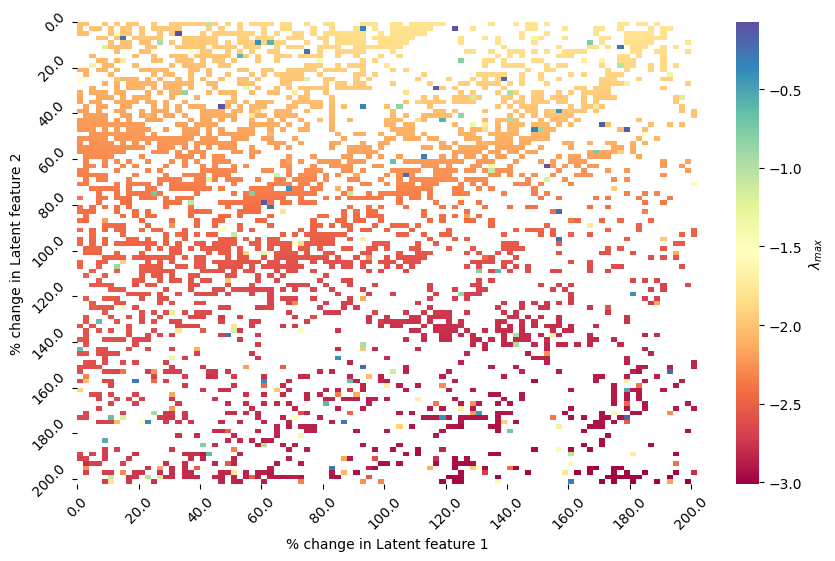

In [14]:
global_min = float('inf')
global_max = float('-inf')
# First pass: Find the min and max values

ixs_to_perturb = [52,51]
name = f'{valid_idx_og}_{ixs_to_perturb[0]}_{ixs_to_perturb[1]}'
this_path = f'latent/{ss_idx}_{repeat}_{gen}/landscape/two/'

# Step 2: Generate the heatmaps with consistent colorbar scale

perturbed_eigs = pd.read_csv(f'{this_path}/sample_{name}_max_eigs.csv').iloc[:,1].values
latent_mat = np.reshape(perturbed_eigs, (101, 101))

# Set values greater than 0 to NaN
latent_mat[latent_mat > 0] = np.nan

plt.figure(figsize=(10, 6))
#plt.title(f'{ss_idx}:{ix}')
#sns.heatmap(latent_mat, cmap='Spectral', vmin=global_min, vmax=global_max)
sns.heatmap(latent_mat, cmap='Spectral', cbar_kws={'label': r'$\lambda_{max}$'})
plt.xticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
plt.yticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
plt.xlabel('% change in Latent feature 1')
plt.ylabel('% change in Latent feature 2')
#plt.savefig(f'{plot_path}/{ix}_latent_heatmap_lambda.svg', dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(f'{plot_path}/{ix}_latent_heatmap_lambda.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()


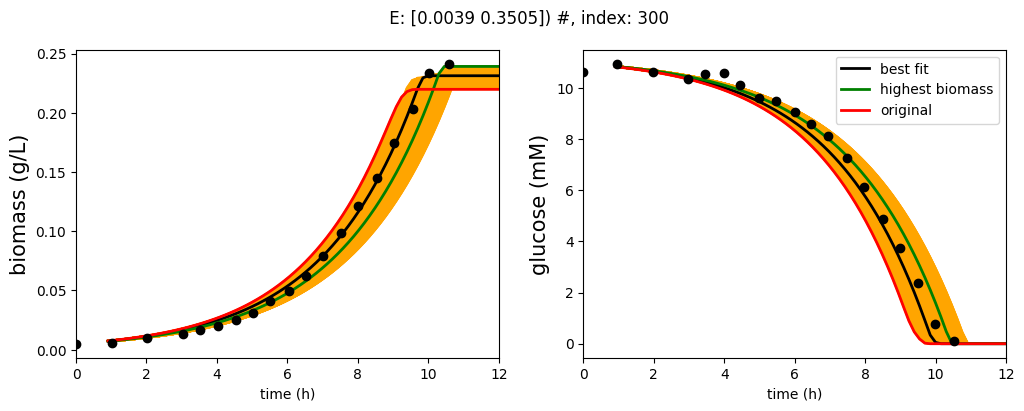

In [15]:
path = f'latent/{ss_idx}_{repeat}_{gen}/landscape/two/'
name_ = f'{valid_idx_og}_{ixs_to_perturb[0]}_{ixs_to_perturb[1]}'

#Load stuff
these_eigs = pd.read_csv(f'{path}sample_{name_}_max_eigs.csv').iloc[:,1].values
valid_eig_idx = np.where(these_eigs<=-0.9)[0]
valid_eigs = these_eigs[valid_eig_idx]


path_to_sol = f'{path}sample_{name_}.csv'
all_sols = pd.read_csv(f'{path_to_sol}')
all_sol_ids = np.unique(all_sols['solution_id'])

## Find models that finished integration and get their final biomasses

all_plot_ix = []
all_final_biomasses = []
for ix in all_sol_ids:
    ix_time = all_sols[all_sols['solution_id'] == ix]['time'].values
    if len(ix_time) == len(T): 
        all_plot_ix.append(ix)
        this_final_biomass = all_sols[all_sols['solution_id'] == ix]['biomass_strain_1'].values[-1]
        all_final_biomasses.append(this_final_biomass*dict_scaling['biomass_strain_1'])
        
best_biomass_ix = np.where(all_final_biomasses == np.max(all_final_biomasses))[0][0]


#figure
fig = plt.figure(figsize = (12,4)) 
plot_ix = 1
for conc, scaling in list(dict_scaling.items()):

    #load experimental data
    exp_ = exp_data[conc]
    mean = exp_[exp_.columns[1]]
    time_exp = exp_[exp_.columns[0]]

    plt.subplot(1,2,plot_ix)

    # Plot simulated data
    for sol_id in all_plot_ix:
        this_sol = all_sols[all_sols['solution_id']==sol_id]
        if len(this_sol[conc])==N_STEPS:
            plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)
            
    
    E_df = calc_E(all_sols, all_plot_ix)
    
    # Find solution with the lowest biomass E and its corresponding E_glc
    min_E_biomass = E_df['E_biomass'].min() # minimum E_biomass
    ix_min_E_biomass = int(E_df[E_df['E_biomass'] == min_E_biomass]['solution_id'].values[0])
    min_E_glc = E_df[E_df['solution_id'] == ix_min_E_biomass]['E_glc'].values[0]
    
    #ix_best_model = valid_idx[ix_min_E_biomass]
    min_E = np.round([min_E_biomass, min_E_glc],4)
    
    
    # Plot best fit
    if len(all_plot_ix)!=0:
        this_sol = all_sols[all_sols['solution_id']==ix_min_E_biomass]
        plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'k', label = 'best fit')

    # Plot highest biomass
    if len(all_plot_ix)!=0:
        this_sol = all_sols[all_sols['solution_id']== 2936]
        plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'green', label = 'highest biomass')

    # Plot original
    plt.plot(T[T_start_ix:], og_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'red', label = 'original')
    
    
    # Plot experimental data
    if len(exp_.columns) > 2:
        lo = exp_[exp_.columns[2]]
        hi = exp_[exp_.columns[3]]
        plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                     fmt='ko', capsize=5)
    else:
        plt.plot(time_exp, mean, 'ko')  
        plt.xlabel('time (h)')
        plt.ylabel(labels[conc], fontsize = 15)
        plt.xlim([0, 12])

    plot_ix+=1
    
fig.suptitle(f' E: {min_E}) #, index: {ix_best_model}')

#plt.savefig(f'{plot_path}/sim_{ss_idx}_{rep}_{gen}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
plt.legend()
plt.show()
plt.close()

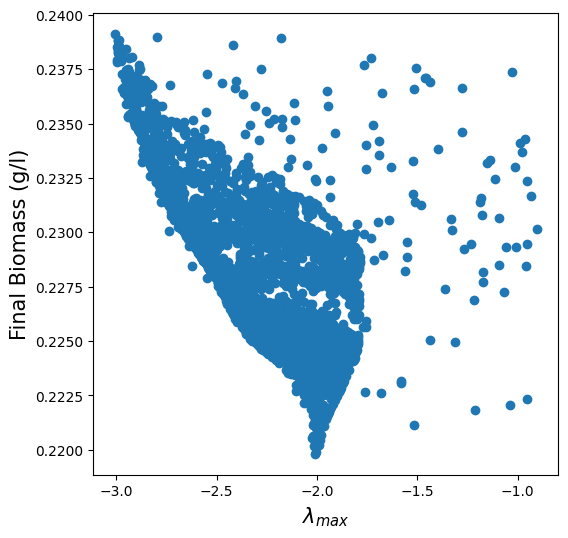

In [16]:
plt.figure(figsize = (6,6))
plt.scatter(valid_eigs[all_plot_ix], all_final_biomasses)
plt.xlabel(r'$\lambda_{max}$', fontsize = 15)
plt.ylabel('Final Biomass (g/l)', fontsize = 15)

plt.show()
plt.close()

### Correlation between growth and $K_M$s

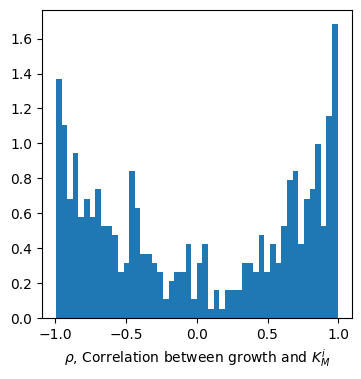

In [33]:
all_rhos = []
all_samples = np.load(f'{path}sample_{name_}.npy')
og_valid_ix = valid_eig_idx[all_plot_ix]

plotted_samples = all_samples[og_valid_ix]
n_kms = np.shape(all_samples)[1]
PLOT = False
for j in range(n_kms):

    these_kms = plotted_samples[:,j]
    this_corr = np.corrcoef(these_kms, all_final_biomasses)[0][1]
    all_rhos.append(this_corr)
    if PLOT:
        
        plt.figure(figsize = (4,4))
        plt.scatter(these_kms, all_final_biomasses, c = valid_eigs[all_plot_ix], cmap = 'gnuplot2', alpha = 0.5)
        plt.title(f'Km: {j}; correlation: {np.round(this_corr, 3)}')
        
        plt.xlabel(r'$\log(K_M)}$', fontsize = 15)
        plt.ylabel(r'Final biomass', fontsize = 15)
        plt.colorbar()
        plt.savefig(f'{path}figures/km/{j}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
        plt.show()
        plt.close()
        
all_rhos = np.array(all_rhos)
plt.figure(figsize = (4,4))
plt.hist(all_rhos, density = True, bins = 50)
plt.xlabel(r'$\rho$, Correlation between growth and $K^i_M$')
plt.show()
plt.close()

In [34]:
# Filter out important Kms based on previous dataset based on visual and manual inspection
limit = 0.9
p_tile = 0.50
pos_cor_ix = np.where(all_rhos >= limit)[0]
dict_values = {}
for this_ix in pos_cor_ix:
    
    these_kms = plotted_samples[:,this_ix]
    max_km = np.max(these_kms)
    min_km = np.min(these_kms)

    p_90 = min_km + (1-p_tile) * (max_km - min_km)
    dict_values[this_ix] = [p_90, max_km]  # take 90th-100th percentile of values
     
pos_cor_ix = np.where(all_rhos <= -limit)[0]
for this_ix in pos_cor_ix:
    
    these_kms = plotted_samples[:,this_ix]
    max_km = np.max(these_kms)
    min_km = np.min(these_kms)

    p_10 = min_km + p_tile * (max_km - min_km)
    dict_values[this_ix] = [min_km, p_10]  # take 0th-10th percentile of values

In [35]:
dict_values

{1: [-11.70437240600586, -11.023123],
 2: [-7.696626663208008, -6.766638],
 9: [-7.376031875610352, -6.5636826],
 23: [-11.11458969116211, -9.871554],
 28: [-9.547507286071777, -8.792891],
 38: [-12.110960006713867, -10.978277],
 42: [-10.235390186309814, -9.455564],
 49: [-8.58276653289795, -8.168575],
 59: [-11.83060359954834, -10.443516],
 64: [-9.922510147094727, -8.808556],
 74: [-8.132719039916992, -7.451782],
 88: [-4.208910942077637, -3.4941788],
 93: [-7.910951614379883, -7.0541286],
 95: [-11.478504180908203, -11.165594],
 104: [-11.741743087768555, -11.002605],
 108: [-5.881006240844727, -5.3625374],
 110: [-9.02107048034668, -8.347271],
 112: [-7.030669212341309, -6.3552017],
 115: [-8.155549049377441, -7.7864494],
 130: [-8.05948543548584, -6.9258194],
 136: [-10.153527736663818, -8.766336],
 155: [-10.53515338897705, -9.900564],
 165: [-14.217203617095947, -13.27559],
 166: [-9.861040115356445, -9.599345],
 168: [-11.545937538146973, -11.081678],
 178: [-8.53762435913086,

In [36]:
# Now replace imp_kms within these ranges in a fresh dataset and see what happens
new_sample = np.load('samples/sample_1000_23.npy')
dummy_sample = new_sample.copy()
for col_idx, (low, high) in dict_values.items():
    dummy_sample[:, col_idx] = np.random.uniform(low, high, size=dummy_sample.shape[0])

np.save(f'samples/mod_sample_1000_23_{limit}_{int(p_tile*100)}.npy', dummy_sample)

In [27]:
# compare
fresh_eigs = pd.read_csv(f'samples/sample_1000_23_max_eigs.csv').iloc[:,1].values
fresh_eigs = fresh_eigs[np.where(fresh_eigs<=0)[0]]

eigs_99_10 = pd.read_csv(f'samples/mod_sample_1000_23_{limit}_{int(p_tile*100)}_max_eigs.csv').iloc[:,1].values
eigs_99_10 = eigs_99_10[np.where(eigs_99_10<=0)[0]]

plt.figure(figsize = (5,5))
plt.hist(fresh_eigs, bins = 20, label = f'original, {len(fresh_eigs)/10}%')
plt.hist(eigs_99_10, bins = 20, alpha = 0.5, label = f'constrained, {len(eigs_99_10)/10}%')

plt.legend()
plt.show()
plt.close()

FileNotFoundError: [Errno 2] No such file or directory: 'samples/mod_sample_1000_23_0.95_20_max_eigs.csv'

## Data Augmentation (Motivation)

In [54]:
ss_idx = 3709
rep =1
gen = 23
path_augmented = f'latent/{ss_idx}_{rep}_{gen}/landscape/two/'

augmented_samples = np.load(f'{path_augmented}sample_82_52_51.npy')
augmented_eigs = pd.read_csv(f'{path_augmented}sample_82_52_51_max_eigs.csv').iloc[:,1].values
aug_stable_ix = np.where(augmented_eigs<0)[0]
aug_unstable_ix = np.where(augmented_eigs>=0)[0]
                          
aug_samples_stable = augmented_samples[aug_stable_ix]
aug_samples_unstable = augmented_samples[aug_unstable_ix]

In [55]:
len(aug_stable_ix)/len(augmented_eigs)

0.29408881482207627

In [56]:
PLOT = False
js_dict = {}
kl_dict = {}
for this_km in range(n_kms):

    x = aug_samples_stable[:, this_km]
    y = aug_samples_unstable[:, this_km]
    bins = np.linspace(min(np.min(x), np.min(y)), max(np.max(x), np.max(y)), 11)

    # Compute histograms and normalize them to get probability distributions
    hist_x, _ = np.histogram(x, bins=bins, density=True)
    hist_y, _ = np.histogram(y, bins=bins, density=True)
    
    # Normalize histograms to sum to 1
    prob_x = hist_x / np.sum(hist_x)
    prob_y = hist_y / np.sum(hist_y)
    
    # Calculate Jensen-Shannon distance
    js_distance = jensenshannon(prob_x, prob_y)
    js_dict[this_km] = js_distance
    kl_dict[this_km] = entropy(prob_x, prob_y)
    if PLOT:
        plt.figure()
        plt.hist(x, label = 'stable', alpha = 0.5, bins =20, density = True)
        plt.hist(y, label = 'unstable', alpha = 0.5, bins = 20, density = True)
        plt.title(f'{this_km}')
        plt.xlabel(rf'Range of $K_M$')
        plt.legend()
        plt.show()
        plt.close()
        
js_dict = dict(sorted(js_dict.items(), key=lambda item: item[1], reverse = True))

### Check distribution of important parameters in augmented and control samples and get bounds

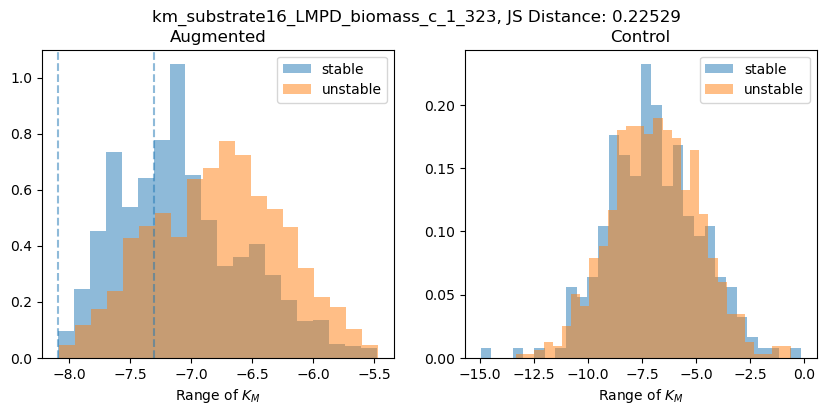

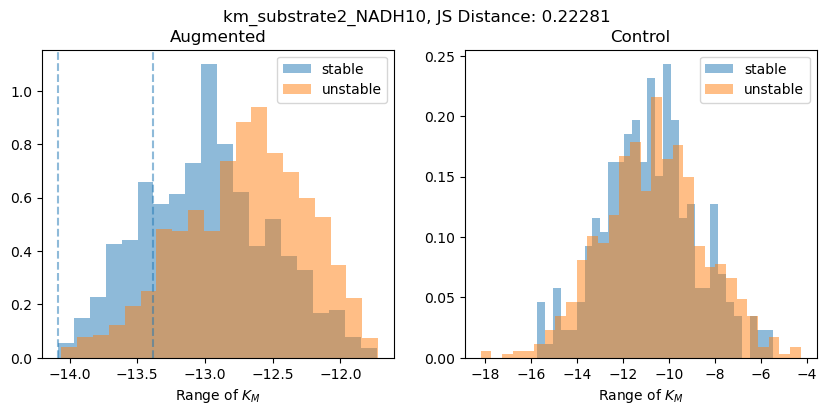

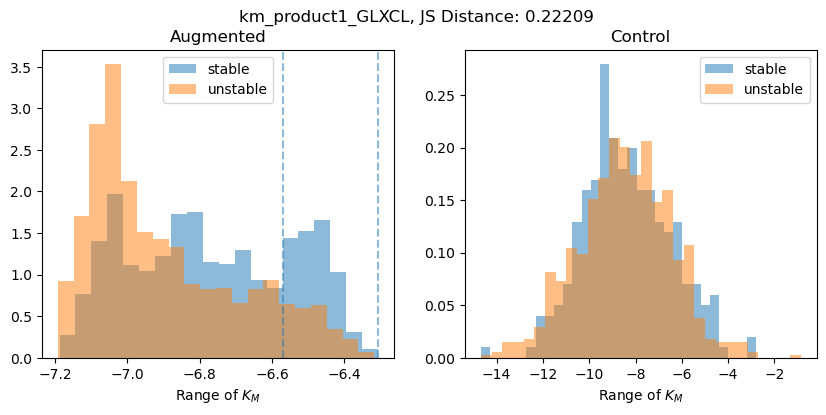

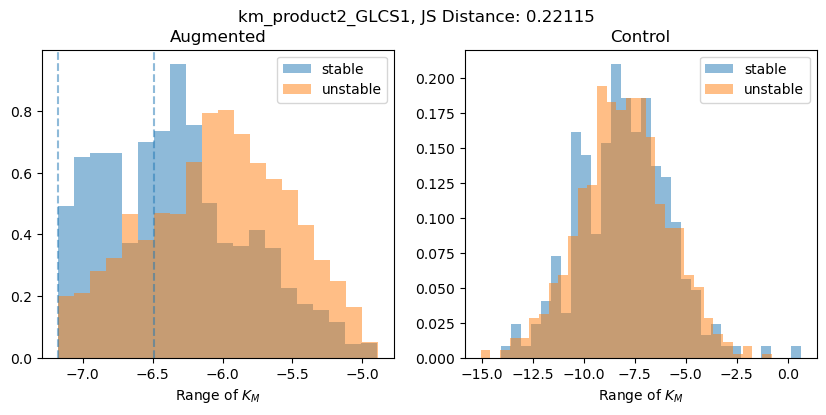

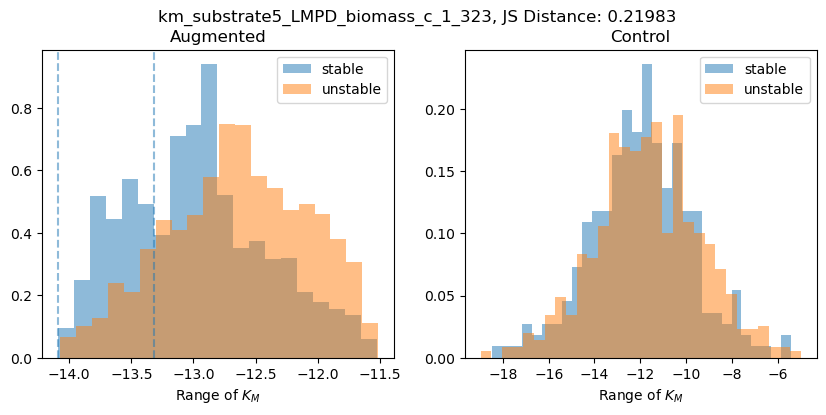

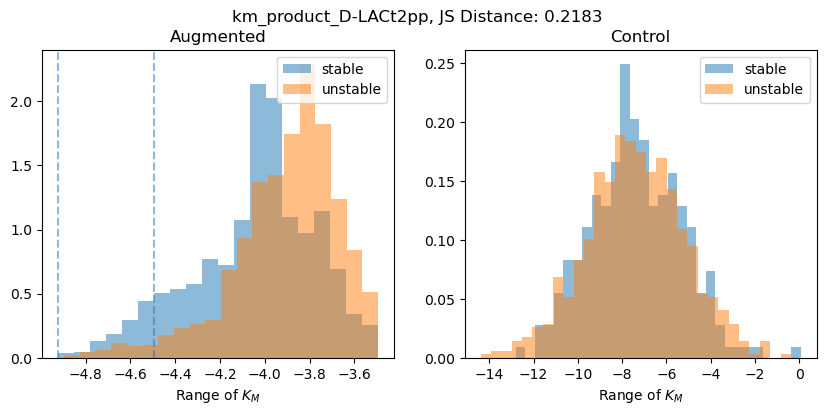

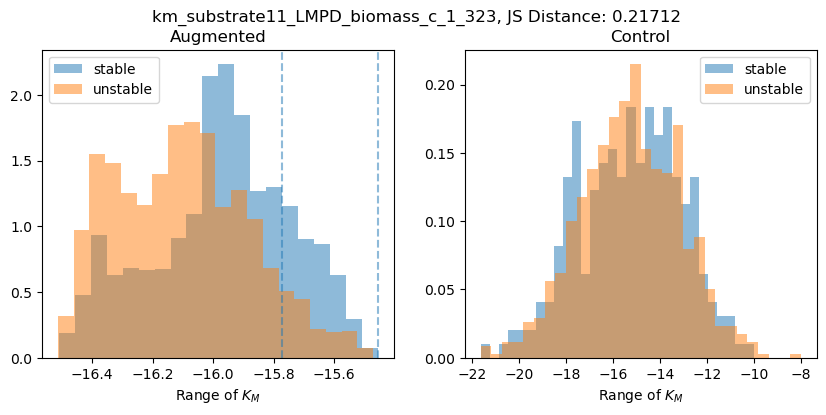

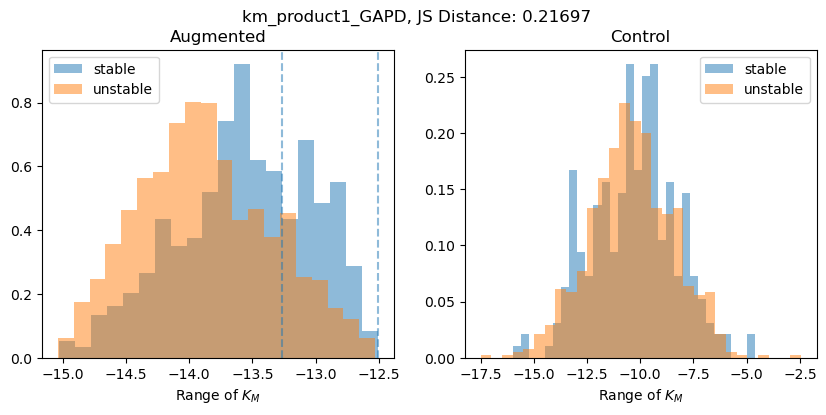

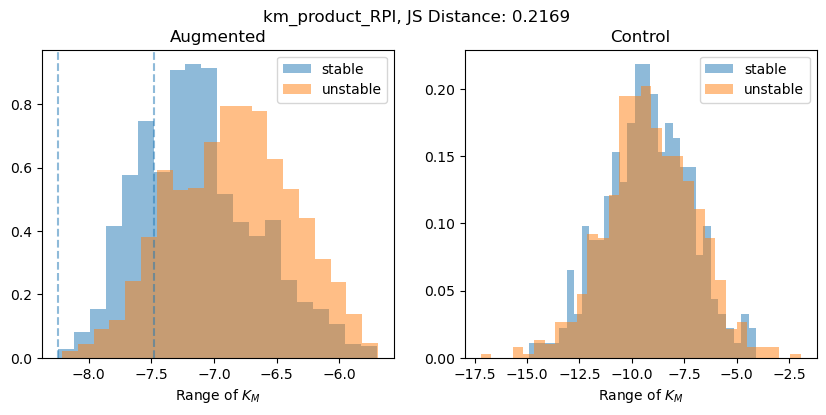

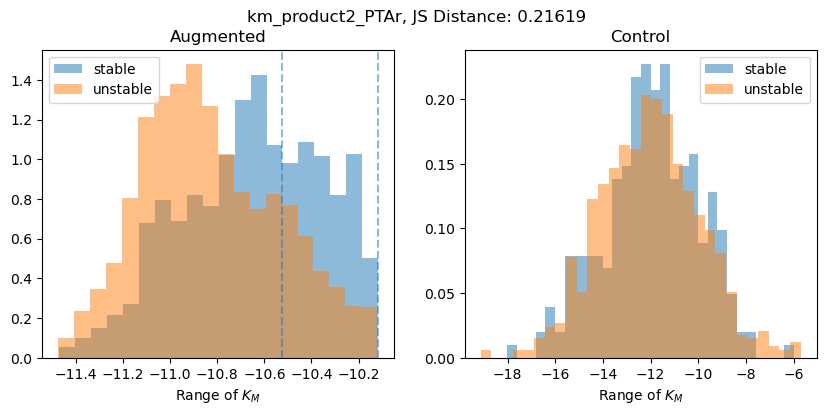

In [59]:
n_consider = 10
p_tile = 0.3  #take 20th-tile values that favors stability
imp_kms = list(js_dict.keys())[:n_consider]

control_sample = np.load('samples/sample_1000_23.npy')
control_eigs = pd.read_csv('samples/sample_1000_23_max_eigs.csv').iloc[:,1].values
control_stable_ix = np.where(control_eigs<0)[0]
control_unstable_ix = np.where(control_eigs>=0)[0]

control_samples_stable = control_sample[control_stable_ix]
control_samples_unstable = control_sample[control_unstable_ix]

dict_bounds = {}

for this_km in imp_kms:    
    
    x_a = aug_samples_stable[:, this_km]
    y_a = aug_samples_unstable[:, this_km]

    x_c = control_samples_stable[:, this_km]
    y_c = control_samples_unstable[:, this_km]

    # Get bounds from median values
    
    x_a_median = np.median(x_a)
    y_a_median = np.median(y_a)
    
    x_a_min = np.min(x_a)
    x_a_max = np.max(x_a)

    if x_a_median > y_a_median:
        p_tile_val = x_a_min + (1-p_tile) * (x_a_max - x_a_min)
        dict_bounds[this_km] = [p_tile_val, x_a_max]  # take 80th-100th percentile of values
    else:
        p_tile_val = x_a_min + p_tile * (x_a_max - x_a_min)
        dict_bounds[this_km] = [x_a_min, p_tile_val]  # take 0th-20th percentile of values
        
    PLOT = True
    
    if PLOT:
        plt.figure(figsize = (10,4))
    
        plt.subplot(121)
        plt.hist(x_a, label = 'stable', alpha = 0.5, bins =20, density = True)
        plt.hist(y_a, label = 'unstable', alpha = 0.5, bins = 20, density = True)
        #plt.axvline(x = np.median(x_a), alpha = 0.5)
        #plt.axvline(x = np.median(y_a), color = 'orange', alpha = 0.5)
    
        plt.axvline(x = dict_bounds[this_km][0], ls = '--', alpha = 0.5)
        plt.axvline(x = dict_bounds[this_km][1], ls = '--',  alpha = 0.5)
        
        plt.title(f'Augmented')
        plt.xlabel(rf'Range of $K_M$')
        plt.legend()
    
        plt.subplot(122)
        plt.hist(x_c, label = 'stable', alpha = 0.5, bins =30, density = True)
        plt.hist(y_c, label = 'unstable', alpha = 0.5, bins = 30, density = True)
        plt.title(f'Control')
        plt.xlabel(rf'Range of $K_M$')
        plt.legend()
    
        plt.suptitle(f'{names_km[this_km]}, JS Distance: {np.round(js_dict[this_km],5)}')
        plt.savefig(f'figures/figure_5/imp_kms/{names_km[this_km]}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
        plt.savefig(f'figures/figure_5/imp_kms/{names_km[this_km]}.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
        plt.show()
        plt.close()

In [53]:
dict_bounds

{291: [-8.090357, -7.307118034362793],
 321: [-14.086224, -13.380185508728028],
 206: [-6.571158981323242, -6.3069572],
 180: [-7.1781445, -6.493221282958984],
 269: [-14.091647, -13.32066011428833],
 88: [-4.923643, -4.494803810119629],
 281: [-15.771430206298827, -15.455051],
 163: [-13.26323938369751, -12.506337],
 437: [-8.2445755, -7.481694030761719],
 427: [-10.522981262207031, -10.116867],
 17: [-12.197260856628418, -11.96591],
 104: [-12.480881, -12.037398147583009],
 150: [-15.566910552978516, -15.06427],
 169: [-13.752193355560303, -13.087826],
 240: [-10.822693, -10.534451389312744],
 59: [-13.217691, -12.38543872833252],
 38: [-13.243643, -12.564033126831054],
 214: [-12.110168, -11.144123458862305],
 64: [-11.036465, -10.36809196472168],
 312: [-13.263821, -12.751487255096436],
 109: [-13.422262287139892, -12.753905],
 2: [-8.626616, -8.068622207641601],
 343: [-11.231295, -10.67843713760376],
 130: [-9.193151, -8.512951850891113],
 166: [-10.122735, -9.965718078613282],
 

In [6]:
## Now replace unstable models with the new bounds
og_sample = np.load('augmentation/og_sample.npy')
og_sample_eigs = pd.read_csv('augmentation/og_sample_max_eigs.csv').iloc[:,1].values
dummy_sample = og_sample.copy()
mask = og_sample_eigs > 0

# Apply transformation only for indices where the mask is True
for col_idx, (low, high) in dict_bounds.items():
    dummy_sample[mask, col_idx] = np.random.uniform(low, high, size=np.sum(mask))

np.save(f'augmentation/new_sample_{n_consider}_{p_tile}.npy', dummy_sample)

NameError: name 'dict_bounds' is not defined

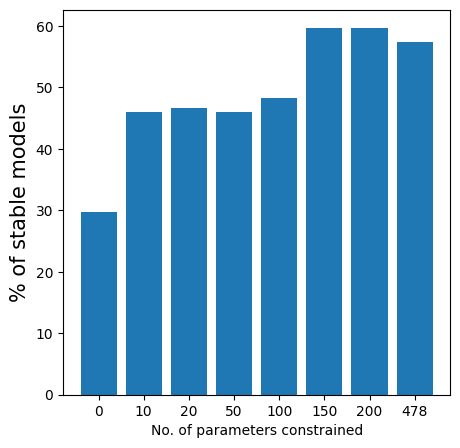

In [5]:
all_stabilities= [0.297*100]
for n_consider in [10,20,50,100,150,200,478]:

    these_eigs = pd.read_csv(f'augmentation/new_sample_{n_consider}_0.3_max_eigs.csv').iloc[:,1].values
    n_stable = len(np.where(these_eigs<=0)[0])
    all_stabilities.append(n_stable/len(these_eigs)*100)

plt.figure(figsize = (5,5))
plt.bar(np.arange(len(all_stabilities)), all_stabilities)
plt.xticks(np.arange(len(all_stabilities)), [0, 10,20,50,100,150, 200,478])
plt.xlabel('No. of parameters constrained')
plt.ylabel('% of stable models', fontsize = 15)
plt.savefig(f'figures/parameter_stability.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
plt.show()

In [8]:
all_stabilities

[29.7,
 46.083717282619354,
 46.740515635721984,
 45.95627879619645,
 48.3285952357612,
 59.65101460641114,
 59.67062052739928,
 57.327712969316735]

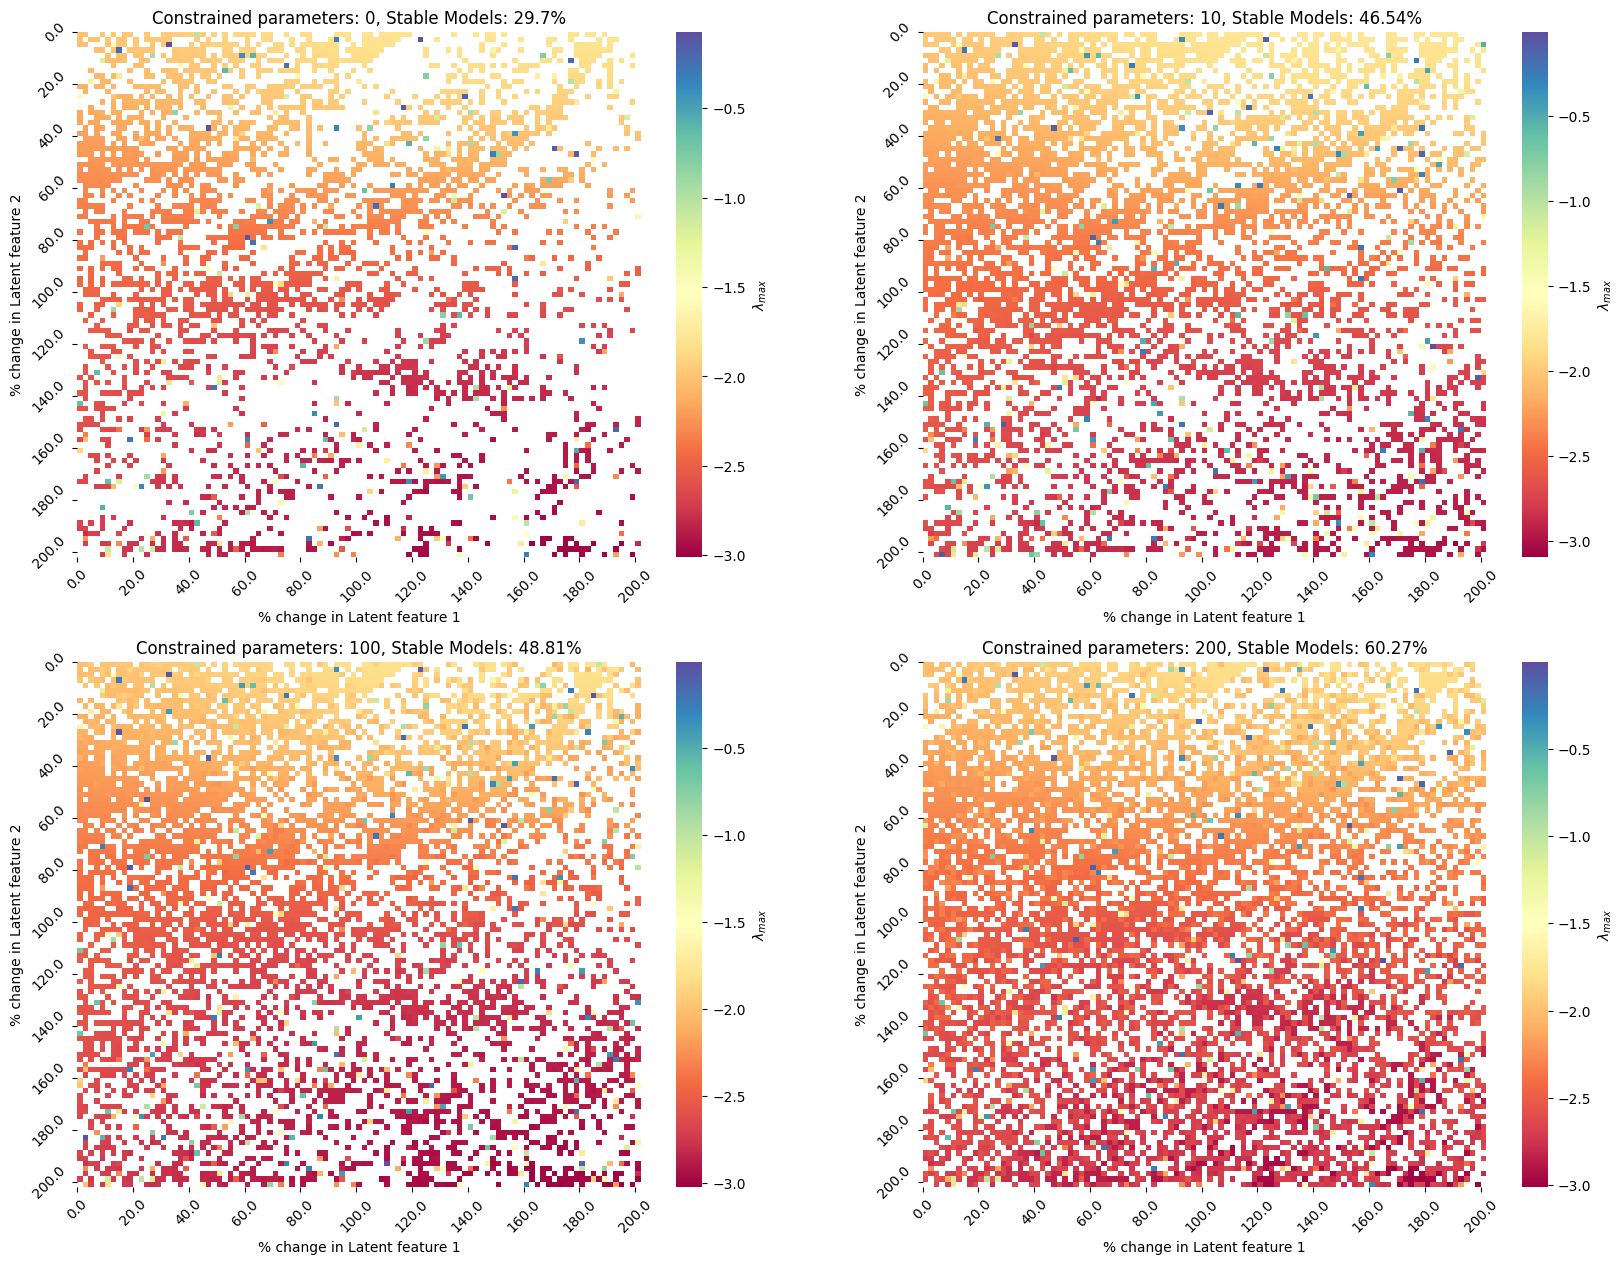

In [78]:
old_eigs = np.reshape(og_sample_eigs, (101, 101))
old_eigs[old_eigs > 0] = np.nan
n_stable = np.count_nonzero(~np.isnan(old_eigs))/len(old_eigs)
plt.figure(figsize=(20, 15))

plt.subplot(221)
sns.heatmap(old_eigs, cmap='Spectral', cbar_kws={'label': r'$\lambda_{max}$'})
plt.xticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
plt.yticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
plt.xlabel('% change in Latent feature 1')
plt.ylabel('% change in Latent feature 2')
plt.title(f'Constrained parameters: 0, Stable Models: {np.round(n_stable, 2)}%')

ix = 2
for n_const in [10, 100, 200]:

    new_eigs = pd.read_csv(f'augmentation/new_sample_{n_const}_0.3_max_eigs.csv').iloc[:,1].values
    new_eigs = np.reshape(new_eigs, (101, 101))
    new_eigs[new_eigs > 0] = np.nan

    n_stable = np.count_nonzero(~np.isnan(new_eigs))/len(new_eigs)
    
    plt.subplot(2,2,ix)
    sns.heatmap(new_eigs, cmap='Spectral', cbar_kws={'label': r'$\lambda_{max}$'})
    plt.xticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
    plt.yticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
    plt.xlabel('% change in Latent feature 1')
    plt.ylabel('% change in Latent feature 2')
    plt.title(f'Constrained parameters: {n_const}, Stable Models: {np.round(n_stable, 2)}%')
    ix+=1
    
plt.show()
plt.close()